## Cell Fate Decision Generative Model

The form of our data: 

After processing, we obtain number density fractions of difference cell types. These are as follows:

$n_b$=number density of pluripotent cells (both markers) per unit area (# 'both' cells in box)

$n_r$=density of red cells (Oct4) (# 'red' cells in box)

$n_g$=density of green cells (Sox2) (# 'green' cells in box)

Between two time steps, we assert the following: 

$$\Delta n_b= n_{entering, b} - n_{leaving, b} + n_{dividing, b} -n_{b\rightarrow g } - n_{g\rightarrow b}$$

Where $n_{entering, b}$ denotes the number of pluripotent cells entering the ROI, $n_{leaving, b}$ denotes the number exiting the ROI, $n_{dividing,b}$ denotes the number of pluripotent cells in the ROI that divide, $n_{b\rightarrow g } $ the number of cells that differentiate to green, and $n_{g\rightarrow b}$ the number of cells that differentiate to blue. 

$$\Delta n_g= n_{entering, g} - n_{leaving, g} + n_{dividing, g} +n_{b\rightarrow g } $$

Where $n_{entering, g}$ denotes the number of green cells entering the ROI, $n_{leaving, g}$ denotes the number exiting the ROI, and $n_{dividing,g}$ denotes the number of green cells in the ROI that divide.  

$$\Delta n_r= n_{entering, r} - n_{leaving, r} + n_{dividing, r} +n_{b\rightarrow r } $$

With variables defined as above. 

We can then convert these to differential equations (modulo some scaling factor):


$$ \frac{d n_b (t,x)}{dt}  = k_{entry}n_b(t,x_{neighbors})+(k_{division}-k_{departure}) n_b(t,x) - (k_{b\rightarrow g } + k_{b \rightarrow r})n_{b}(t,x) $$

$$ \frac{d n_g (t,x)}{dt} = k_{entry}n_g(t,x_{neighbors})+(k_{division}-k_{departure}) n_g(t,x) + k_{b\rightarrow g } n_{b}(t,x) $$

$$ \frac{d n_r (t,x)}{dt} = k_{entry}n_r(t,x_{neighbors})+(k_{division}-k_{departure}) n_r(t,x) + k_{b\rightarrow r } n_{b}(t,x) $$

Once we include noise, numerically solving this set of differential equations should recapitulate our data. To simplify analysis, we may choose to approximate $x_{neighbors}$ by $x$ because we expect density to vary slowly over the scale of a small number of analysis areas. Additionally, we have assumed above that $k_{division}$ is the same for all three cell types, as well as rates of motion. This should hold because these cell types are very similar, and are not readily distinguishable without these tags. 

The rates $k$ above are the average rates; in practice, the number densities will be non-deterministic due to various sources of error including: 

- errors due to cell counting algorithm (stochasticity from the observation)
    - To process our data set, we use a black-box cell counting software from MIT's Broad Institute. While this software is very good, it is still not perfect (and is also not as good as the naked eye). It will make errors due to issues such as image quality and resolution (blurring cell outlines), a wide spread of cell sizes (this type of segmentation algorithm usually does better when cells are relatively uniform in size), and possible overlap between cells. Because this is a mixture of many types of uncertainties, each of which has an unknown distribution. A gaussian is the most conservative way of estimating error, so we will treat these errors as gaussian with a single, non-time-varying $\sigma$ and mean 0. To determine the value of $\sigma_{obs}$ we will manually count the cells in a small subset of our images, then compare our counts against the actual count to determine the error of the computer algorithm. 
    
- stochasticity of cell behavior
    - In this particular case, researchers have observed that the Sox2 reporter is unstable--some cells will silence their fluorescently tagged Sox2 while maintaining their untagged copy.  We expect this $k_{silence}$ to be significantly smaller than the other values, but we should nonetheless include it. However, it is not clear what would be the distribution of uncertainties originated from this Poisson loss process of cell reporters. Including this uncertainties, the model will present statistical noise, and to be mostly conservative, we may assume the uncertainty to be Gaussian with variance $\sigma_{cells}^2$. The estimation of this variance requires further discussion.
    
$$ \frac{d n_b^* (t,x)}{dt} = \frac{d n_b (t,x)}{dt}-k_{silence}  n_b(t,x) $$ 
$$ \frac{d n_g^* (t,x)}{dt} = \frac{d n_g (t,x)}{dt}-k_{silence} n_g(t,x) $$
$$ \frac{d n_r^* (t,x)}{dt} = \frac{d n_r (t,x)}{dt}+k_{silence} n_b(t,x) $$




Let $\vec{n} = (n_b,n_g,n_r)$ (evaluated at any (x,t). Let $\vec{k}$ denote the parameter vector for rates $(k_{entry}, k_{departure}, k_{division}, k_{b \rightarrow g}, k_{b \rightarrow r}, k_{silence})$. We will numerically solve the above system to find $m(\vec{n}|\vec{k})$. Let $\vec{e }$ denote the gaussian observation error in $\vec{n}$ and let $\vec{\epsilon}$ denote the gaussian measurement observation error in $\vec{n}$ (as described in Gregory 4.8.2).

Then the prediction $\vec{\mathfrak{n}}$ from our generative model is:

$$\vec{z} = m(\vec{\mathfrak{n}}|\vec{k}) + \vec{e_i} + \vec{\epsilon_i}$$

We can then show, as Gregory equation 4.5:

$$p ( N| M, \vec{k},I) =\frac{1}{\sqrt{2 \pi (\sigma^2_{obs}+\sigma^2_{cells}}) } \exp \{ \frac{-(\vec{N}-\vec{m}(\vec{n}|\vec{k}))^2}{2(\sigma_{obs}^2+\sigma_{cells}^2)} \}$$

(Gregory 4.51 essentially)

Next we need to get from a single point in (x,t) to the full three dimensions (x,y,t) of our data. We assume that observational noise is independent (so will be separable). Noise inherent to our system is the sum of noise from many biological processes on different time-scales. We will assume this noise is independent our data points can still be treated as independent. We thus can multiply the likelihood of each data point to get the final likelihood function for our generative model. Let $T$ by the total number of time steps and $B$ be the total number of bins per time step.

$$p(D|M, \vec{k},I)=(2\pi)^{-B T /2} \{ \prod_{i=1}^T\prod_{j=1}^{B} (\sigma_{obs}^2 +\sigma_{cells}^2)^{-1/2} \} \exp \{ \sum_{i,j=1}^{i=T,j=B} (\frac{-(\vec{n_{i,j}}-\vec{m}(\vec{n_{i,j}}|\vec{k}))^2}{2(\sigma_{obs}^2+\sigma_{cells}^2)} ) \}$$

### 4/16
### Simplification of the model (Temporary)

If we assume the rate of movement of cells at each boundary of a bin to be same for all four boundaries, we have 

$$ \frac{d n_b (t,x,y)}{dt}  = k_{move}[n_b(t,x_{neighbors},y_{neighbors})- n_b(t,x,y)]+k_{division} n_b(t,x,y) - (k_{b\rightarrow g } + k_{b \rightarrow r}-k_{silence})n_{b}(t,x,y) $$
$$ \frac{d n_g (t,x,y)}{dt} = k_{move}[n_g(t,x_{neighbors},y_{neighbors})- n_g(t,x,y)]+k_{division}n_g(t,x,y) + (k_{b\rightarrow g }- k_{silence})n_{g}(t,x,y) $$
$$ \frac{d n_r (t,x,y)}{dt} = k_{move}[n_r(t,x_{neighbors},y_{neighbors})- n_r(t,x,y)]+k_{division}n_r(t,x,y) + (k_{b\rightarrow r }+ k_{silence})n_{r}(t,x,y) $$

where $n_{\alpha}(t,x_{neighbors},y_{neighbors})- n_{\alpha}(t,x,y) =  \sum\limits_{i,j=-1,1}\left[n_{\alpha}(t,x+i,y+j)- n_{\alpha}(t,x,y) \right]$

As a result, the system of differential equations at each bin will be coupled to differential equations in the neighboring bins. Thus, our model is in fact a system of partial differential equations. However, to have a working code within a week, we first further simplify our model and set $k_{move}=0$:

$$ \frac{d n_b (t,x,y)}{dt}  = k_{division} n_b(t,x,y) - (k_{b\rightarrow g } + k_{b \rightarrow r}-k_{silence})n_{b}(t,x,y) $$
$$ \frac{d n_g (t,x,y)}{dt} = k_{division}n_g(t,x,y) + (k_{b\rightarrow g }- k_{silence})n_{g}(t,x,y) $$
$$ \frac{d n_r (t,x,y)}{dt} = k_{division}n_r(t,x,y) + (k_{b\rightarrow r }+ k_{silence})n_{r}(t,x,y) $$

### Simplification of likelihood function (Temporary)

The loss of green reporter will be Poisson process with rate $k_{silence}$. Then expected number of loss will be approximated as $n_{silence}=k_{silence} \pm \sqrt{k_{silence}}$. This uncertainty will depend on $k_{silence}$, which makes our analysis trickier. Thus, for now, we ignore this loss term and simplify our model as following:

$$ \frac{d n_b (t,x,y)}{dt}  = k_{division} n_b(t,x,y) - (k_{b\rightarrow g } + k_{b \rightarrow r})n_{b}(t,x,y) $$
$$ \frac{d n_g (t,x,y)}{dt} = k_{division}n_g(t,x,y) + k_{b\rightarrow g } n_{g}(t,x,y) $$
$$ \frac{d n_r (t,x,y)}{dt} = k_{division}n_r(t,x,y) + k_{b\rightarrow r } n_{r}(t,x,y) $$

Then, we will only have Gaussian measurement error so that our likelihood function is simplified to 
$$p(D|M, \vec{k},I)=(2\pi)^{-B T /2} \{ \prod_{i=1}^T\prod_{j=1}^{B} (\sigma_{obs}^2)^{-1/2} \} \exp \{ \sum_{i,j=1}^{i=T,j=B} (\frac{-(\vec{n_{i,j}}-\vec{m}(\vec{n_{i,j}}|\vec{k}))^2}{2\sigma_{obs}^2} ) \}$$

### Inference with model.py

Currently, we do not have two models for comparison. Therefore, for now, we will compare likelihood function of two different set of parameters given the simulated dataset. The simulated dataset is created with $\vec{k}=[k_{div}, k_{bg}, k_{br}]=[0.1, 0.4, 0.2]$ for $2 \times 2$ bins and 30 unit timestep.

## Update in the last week

We included back the $k_{move}$ term in order for better infered values of k's. So now our model becomes a system of differentiation equation,

$$\frac{\partial n_b}{\partial t}=k_{move}\nabla^2 n_b+k_{division}n_b-k_{b\rightarrow g}n_b-k_{b\rightarrow r}n_b$$
$$\frac{\partial n_g}{\partial t}=k_{move}\nabla^2 n_g+k_{division}n_g+k_{b\rightarrow g}n_b$$
$$\frac{\partial n_r}{\partial t}=k_{move}\nabla^2 n_r+k_{division}n_r+k_{b\rightarrow r}n_b$$

where the $k_{move}$ term is modelled by diffusion, namely the divigence of flow of the cell ($\vec{J}$), i.e. $\nabla\cdot\vec{J}\propto\nabla\cdot\nabla n=\nabla^2 n$.<br/>

We noticed that the error term is actually proportional to the cell density such that
$$y_b=m_b(1+\Delta n)=m_b+m_b\Delta n$$
where $y_b$ is the cell density of certain cell type in bin $b$ measured by the cell counting software (and Python), $m_b$ is the true value and $\Delta n$ is the percentage difference between them. The error term $m_b\Delta n$ is changing for different cell density $m_b$. To make our likelihood easier to work with, it is better to have an error term independent of the cell density. To do this, we can take the logarithm of both sides,
$$\ln y_b=\ln m_b+\ln(1+\Delta n)$$
in which the error term is $\ln(1+\Delta n)$ that is not dependent on $m_b$.<br/>

To find the mean and variance of $\ln (1+\Delta n)$, we counted cell number in 20 bins of the cell image at time 0 and compared it with the values measured by the Python. We found that the distribution of $\ln (1+\Delta n)$ is roughly Gaussian with mean -0.15 and standard derivation $\approx$ 0.104
<img src="Vaiance.png" width="400" height="400">

So now the probability to get $\ln y_b$ in the measurement is
$$p(\ln y_b|M,\vec{k},I)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(\ln y_b-\ln m_b-\mu)^2}{2\sigma^2})$$
where $\mu=-0.15$ and $\sigma=0.104$.<br/>

However, the likelihood of model should be in terms of $p(y)$ instead of $p(\ln y)$. We could do the conversion by considering $$p(y_b)dy_b=p(\ln y_b)d(\ln y_b)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(\ln y_b-\ln m_b-\mu)^2}{2\sigma^2})\frac{dy_b}{y_b}$$
which implies
$$p(y_b)=\frac{1}{y_b\sqrt{2\pi\sigma^2}}\exp(-\frac{(\ln y_b-\ln m_b-\mu)^2}{2\sigma^2})$$

In this way, the likelihood of our model would be the product of these $p(y_b)$ over all bins $b$,
$$\mathcal{L}=\prod_{b=1}^N p(y_b)$$
where N is the total bins number. Hence the log likelihood would be
$$\ln\mathcal{L}=\ln(\prod_{b=1}^N p(y_b))=\sum_{b=1}^N\ln p(y_b)$$
$$\implies \ln\mathcal{L}=\sum_{b=1}^N -\frac{1}{2}\ln(2\pi\sigma^2)-\ln y_b-\frac{(\ln y_b-\ln m_b-\mu)^2}{2\sigma^2}$$

For the prior, since we do not know anything about the values of the parameters $k$'s and we want to include 0 in them, we chose to use the uniform prior from $0$ to $\infty$. But later we found that the hourly change of the cell number is much less than one. So we limit the upper values of the $k$'s to be less than 1.

For the model comparison, we are going to compare the models with and without the diffusion terms (namely the previous 'temporary' model and the model described here).

In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from cellfate import model, io, celldensity

# Parameters to calculate likelihood function
params1 = [0.05, 0.6, 0.1]
params2 = [0.1, 0.4, 0.2]

# Create CellDen class object with simulated data
testobject = celldensity.CellDen(pd.read_pickle('cellfate/simulated_data_2x2_30.pkl'))

# Calculate log_likelihood function
# sigma_n is set arbitrarily as 0.4
val_1 = model.log_likelihood(params1, testobject, 0.4)
val_2 = model.log_likelihood(params2, testobject, 0.4)

print("Likelihood function value for parameter set 1 is %.5f" %(np.exp(val_1)))
print("Likelihood function value for parameter set 2 is %.5f" %(np.exp(val_2)))

Likelihood function value for parameter set 1 is 0.00000
Likelihood function value for parameter set 2 is 0.38550


It makes sense that parameter set 2 gives higher value than parameter set 1 as parameter set 2 was used to create the simulated dataset.

Now, for demonstration, we plot how the number of each type of cell changes in each bin via heatmaps for five evenly divided timestep.

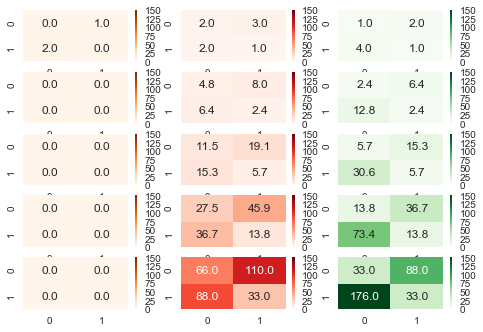

In [2]:
model.plotMap(model.diffeqSolve(params2, testobject), testobject.tot_time, 5)

To check if our code works well, let's run MCMC on our model.

In [3]:
import emcee
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as op

# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.5, 0.5])
res = op.fmin(model.negative_log_posterior, x0, args=(testobject, 0.4))

print(res)

Optimization terminated successfully.
         Current function value: 0.953209
         Iterations: 120
         Function evaluations: 216
[ 0.1         0.39997787  0.19998873]


CPU times: user 33.6 s, sys: 181 ms, total: 33.8 s
Wall time: 34.5 s
Done


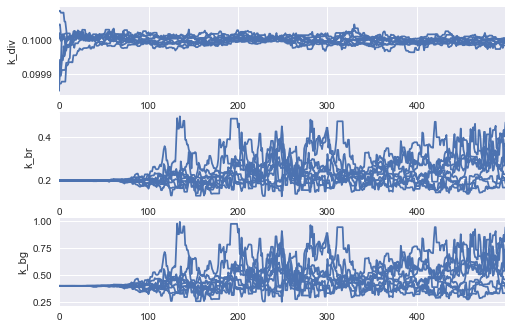

In [4]:
# We have 3 parameters. 
# We use 20 walkers and 500 steps, which turns out to be a sufficient number.
ndim = 3
nwalkers = 20
nsteps = 500
init_params = res

# Starting positions in Gaussian ball
starting_positions = [init_params + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_posterior, 
                                args=(testobject, 0.4))

# Run the sampler.
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

# Let's plot 10 walkers from the samler chain to observe convergence.
fig, (ax_k_div, ax_k_br, ax_k_bg) = plt.subplots(3)
ax_k_div.set(ylabel='k_div')
ax_k_bg.set(ylabel='k_bg')
ax_k_br.set(ylabel='k_br')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_k_bg)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_k_br)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


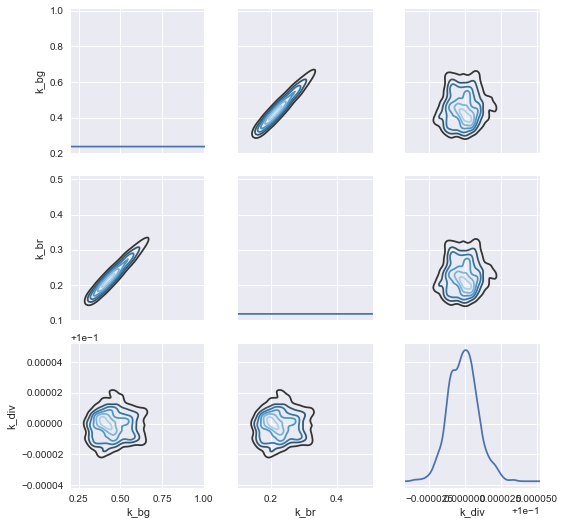

In [5]:
# Since V_b converges around 300, let's set burnin time as 300 steps.
samples = sampler.chain[:,300:,:]

# reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
traces = samples.reshape(-1, ndim).T

# Create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_bg': traces[1], 'k_br': traces[2]})

# Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
g = sns.PairGrid(parameter_samples)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

We obtain the result which agrees with the parameters used to create the simulated data, as expected.

### 4/24
## Inference with the actual data

Now, let's use the actual data to make an inference. Firstly, let's plot the location of cells of each type. Note that the data contains total 175 steps of unit time.

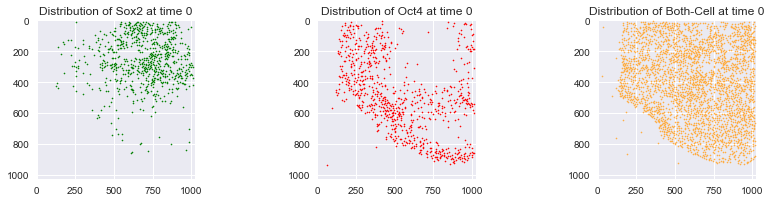

In [6]:
celldensity.draw_cell_loc('full-data.csv', 'Sox2', 'Oct4', 0)

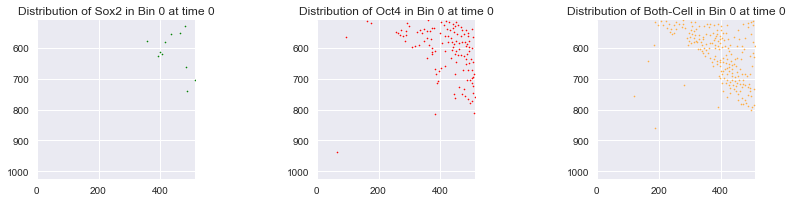

In [7]:
# Following plot shows that the bin numbering starts from the bottom left corner in this plot.
celldensity.draw_cell_loc('full-data.csv', 'Sox2', 'Oct4',  0, BinDiv=2, bin_i=0, bin_j=0)

Let's create celldensity object and observe the change of cell numbers in 2x2 bin.

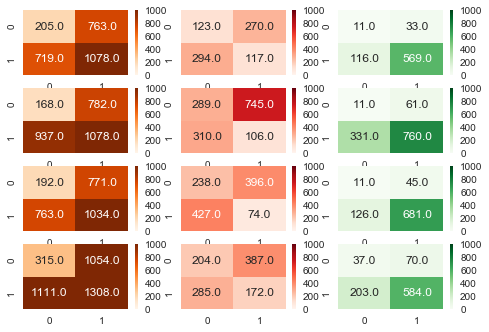

In [8]:
# Create object
testobject = io.read('full-data.csv', 'Sox2', 'Oct4', 2)
testobject.plotMap(4)

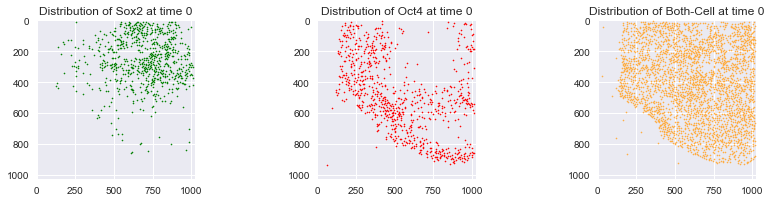

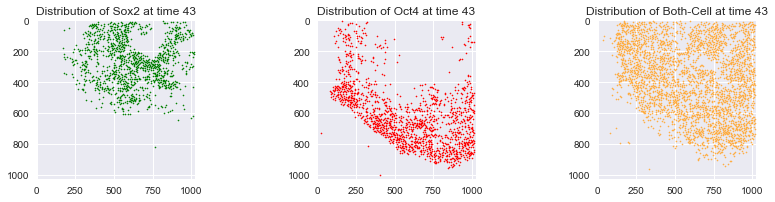

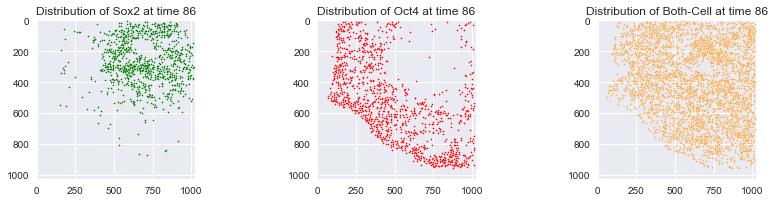

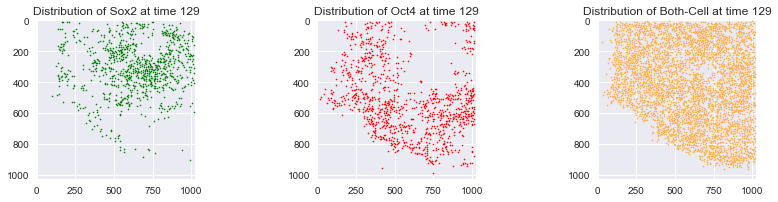

In [9]:
# Plot the images of the cell locations over time
steps = 175
plotNum = 4
for i in range(plotNum):
    celldensity.draw_cell_loc('full-data.csv', 'Sox2', 'Oct4', i*int(steps/plotNum))

Note that the y-axis is inverted; zero is located at the top instead of bottom. Since our original image is generated by matlab which inverts the y-axis, we intentionally inverted y-axis in our python script so that comparison would be easier. Thus, in this plot, the bin numering starts from bottom left corner while in our heatmap using the actual dataframe, the bin numbering starts from the top left corner.

It is difficult to observe monotonic trend of each type of cell. As the number of both-cells is increasing, we expect to retrieve certain division rate, but the transition from both-cell to Oct4 (red) or Sox2 (green) is not clear. For the estimate, we repeat the inference done above with actual data.

In [10]:
# Parameters to calculate likelihood function
params1 = [0.05, 0.6, 0.1]
params2 = [0.1, 0.4, 0.2]

# Calculate log_likelihood function
# sigma_n is set arbitrarily
val_1 = model.log_likelihood(params1, testobject, 1000)
val_2 = model.log_likelihood(params2, testobject, 1000)

print("Log-Likelihood function value for parameter set 1 is %.5f" %(val_1))
print("Log-Likelihood function value for parameter set 2 is %.5f" %(val_2))

Log-Likelihood function value for parameter set 1 is -21355.44498
Log-Likelihood function value for parameter set 2 is -201271.96578


In [12]:
# Find MAP values
# Initial guess
x0 = np.array([0.5, 0.5, 0.5])
res = op.fmin(model.negative_log_posterior, x0, args=(testobject, 1000))

print(res)

Optimization terminated successfully.
         Current function value: 16773.756923
         Iterations: 168
         Function evaluations: 318
[  7.04165400e-10   6.90011107e-01   6.73230834e-01]


CPU times: user 26.6 s, sys: 185 ms, total: 26.8 s
Wall time: 27.9 s
Done


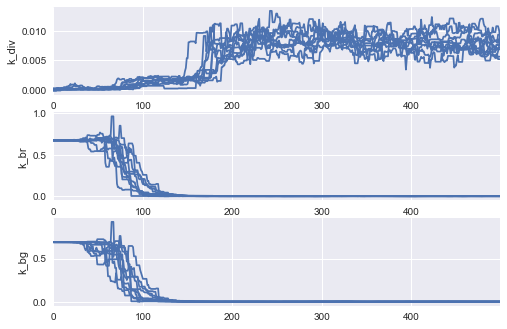

In [13]:
# We have 3 parameters. 
# We use 20 walkers and 500 steps, which turns out to be a sufficient number.
ndim = 3
nwalkers = 30
nsteps = 500
init_params = res

# Starting positions in Gaussian ball
starting_positions = [init_params + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_posterior, 
                                args=(testobject, 1000))

# Run the sampler.
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

# Let's plot 10 walkers from the samler chain to observe convergence.
fig, (ax_k_div, ax_k_br, ax_k_bg) = plt.subplots(3)
ax_k_div.set(ylabel='k_div')
ax_k_bg.set(ylabel='k_bg')
ax_k_br.set(ylabel='k_br')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_k_bg)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_k_br)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


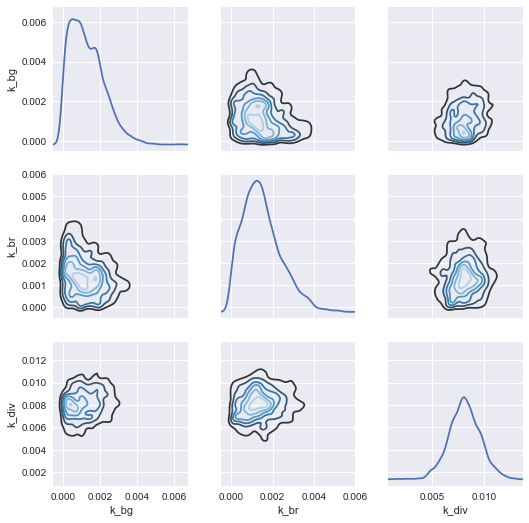

In [14]:
# Since V_b converges around 300, let's set burnin time as 300 steps.
samples = sampler.chain[:,300:,:]

# reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
traces = samples.reshape(-1, ndim).T

# Create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_bg': traces[1], 'k_br': traces[2]})

# Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
g = sns.PairGrid(parameter_samples)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

There exists about one order of magnitude difference between $k_{div}$ and $k_{bg}$&$k_{br}$. While we expect to see transition, it seems our model is too simplified so that $k_{bg}$&$k_{br}$ is overwhelmed by $k_{div}$.

In [15]:
testobject = io.read('full-data.csv', 'Sox2', 'Oct4', 12)
# Find MAP values
# Initial guess
x0 = np.array([0.05, 0.1, 0.1])
res = op.fmin(model.negative_log_posterior, x0, args=(testobject, 1000))

print(res)

Optimization terminated successfully.
         Current function value: 591703.104084
         Iterations: 106
         Function evaluations: 207
[  1.14826104e-03   1.86073983e-02   6.57280520e-08]


CPU times: user 4min 23s, sys: 898 ms, total: 4min 24s
Wall time: 4min 26s
Done


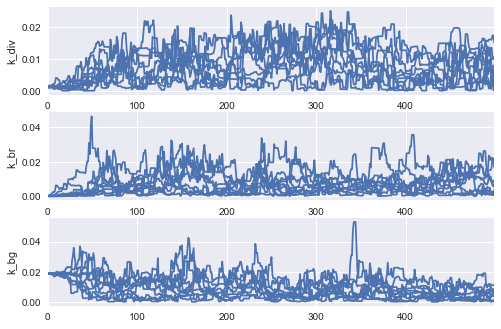

In [16]:
# We have 3 parameters. 
# We use 20 walkers and 500 steps, which turns out to be a sufficient number.
ndim = 3
nwalkers = 20
nsteps = 500
init_params = res

# Starting positions in Gaussian ball
starting_positions = [init_params + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_posterior, 
                                args=(testobject, 1000))

# Run the sampler.
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

# Let's plot 10 walkers from the samler chain to observe convergence.
fig, (ax_k_div, ax_k_br, ax_k_bg) = plt.subplots(3)
ax_k_div.set(ylabel='k_div')
ax_k_bg.set(ylabel='k_bg')
ax_k_br.set(ylabel='k_br')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_k_bg)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_k_br)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


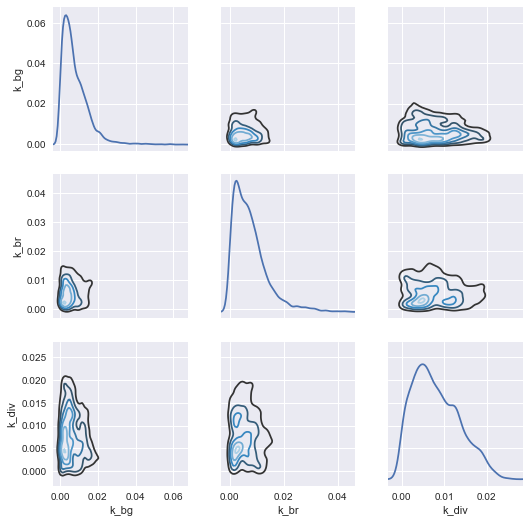

In [17]:
# Since V_b converges around 300, let's set burnin time as 300 steps.
samples = sampler.chain[:,300:,:]

# reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
traces = samples.reshape(-1, ndim).T

# Create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_bg': traces[1], 'k_br': traces[2]})

# Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
g = sns.PairGrid(parameter_samples)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

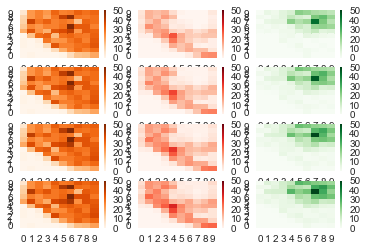

In [18]:
%matplotlib inline
theta = [0.006, 0.002, 0.002]
grid = model.diffeqSolve(theta, testobject)

time_step = int(testobject.tot_time/plotNum)
grn = grid[0,:,:,:]
red = grid[1,:,:,:]
both = grid[2,:,:,:]
plotNum=4
# Plot heatmap for each time i*time_step
for i in range(plotNum):
    plt.subplot(plotNum,3,1+i*3)
    ax_b = sns.heatmap(both[1:-1,1:-1,i*time_step], vmin=0, vmax=50, 
                cmap="Oranges")
    ax_b.invert_yaxis()

    plt.subplot(plotNum,3,2+i*3)
    ax_r = sns.heatmap(red[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Reds")
    ax_r.invert_yaxis()

    plt.subplot(plotNum,3,3+i*3)
    ax_g = sns.heatmap(grn[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                cmap="Greens")
    ax_g.invert_yaxis()


In [3]:
sample = model.diffeqSolve(params2, testobject)
sample_df = model.np2pd(sample, 2)
sample_df

Sox2                                           Oct4              \
            0           1           2          3           0           1   
0    1.000000    2.000000    4.000000   1.000000    2.000000    3.000000   
1    1.156842    2.763147    5.526293   1.156842    2.313684    3.695257   
2    1.338283    3.413456    6.826912   1.338283    2.676566    4.383294   
3    1.548182    4.053531    8.107061   1.548182    3.096364    5.123129   
4    1.791002    4.739828    9.479656   1.791002    3.582004    5.951918   
5    2.071906    5.507622   11.015244   2.071906    4.143812    6.897623   
6    2.396868    6.383219   12.766439   2.396868    4.793735    7.985345   
7    2.772797    7.390057   14.780114   2.772797    5.545594    9.240622   
8    3.207687    8.551870   17.103740   3.207687    6.415375   10.691310   
9    3.710787    9.894485   19.788970   3.710787    7.421574   12.368817   
10   4.292794   11.446993   22.893987   4.292794    8.585588   14.309085   
11   4.966084   13.242670   26.485339   4.966084    9.932168   16.553503   
12   5.744974   15.319824   30.639647   5.744974   11.489948   19.149860   
13   6.646027   17.722686   35.445371   6.646027   13.292053   22.153396   
14   7.688402   20.502380   41.004759   7.688402   15.376804   25.627993   
15   8.894265   23.718028   47.436057   8.894265   17.788531   29.647544   
16  10.289259   27.438017   54.876034  10.289259   20.578517   34.297525   
17  11.903045   31.741451   63.482902  11.903046   23.806091   39.676816   
18  13.769942   36.719842   73.439684  13.769942   27.539883   45.899804   
19  15.929645   42.479053   84.958105  15.929645   31.859291   53.098816   
20  18.428081   49.141548   98.283096  18.428081   36.856162   61.426935   
21  21.318376   56.849001  113.698002  21.318376   42.636752   71.061251   
22  24.661990   65.765306  131.530612  24.661990   49.323981   82.206632   
23  28.530023   76.080060  152.160121  28.530024   57.060047   95.100075   
24  33.004726   88.012600  176.025202  33.004726   66.009452  110.015751   
25  38.181250  101.816663  203.633327  38.181250   76.362500  127.270829   
26  44.169669  117.785780  235.571563  44.169669   88.339338  147.232225   
27  51.097323  136.259524  272.519053  51.097324  102.194647  170.324406   
28  59.111524  157.630726  315.261456  59.111525  118.223048  197.038408   
29  68.382687  182.353827  364.707659  68.382688  136.765374  227.942284   

                          Both                                   
             2          3    0             1             2    3  
0     2.000000   1.000000  0.0  1.000000e+00  2.000000e+00  0.0  
1     2.763147   1.156842  0.0  4.826474e-01  9.652948e-01  0.0  
2     3.413456   1.338283  0.0  2.329485e-01  4.658970e-01  0.0  
3     4.053531   1.548182  0.0  1.124320e-01  2.248640e-01  0.0  
4     4.739828   1.791002  0.0  5.426500e-02  1.085300e-01  0.0  
5     5.507622   2.071906  0.0  2.619087e-02  5.238173e-02  0.0  
6     6.383219   2.396868  0.0  1.264095e-02  2.528191e-02  0.0  
7     7.390057   2.772797  0.0  6.101124e-03  1.220225e-02  0.0  
8     8.551870   3.207687  0.0  2.944692e-03  5.889385e-03  0.0  
9     9.894485   3.710787  0.0  1.421247e-03  2.842496e-03  0.0  
10   11.446993   4.292794  0.0  6.859606e-04  1.371924e-03  0.0  
11   13.242670   4.966084  0.0  3.310766e-04  6.621543e-04  0.0  
12   15.319824   5.744974  0.0  1.597931e-04  3.195866e-04  0.0  
13   17.722686   6.646027  0.0  7.712312e-05  1.542474e-04  0.0  
14   20.502380   7.688402  0.0  3.722455e-05  7.444706e-05  0.0  
15   23.718028   8.894265  0.0  1.796647e-05  3.593216e-05  0.0  
16   27.438017  10.289259  0.0  8.671548e-06  1.734287e-05  0.0  
17   31.741451  11.903046  0.0  4.185134e-06  8.370460e-06  0.0  
18   36.719842  13.769942  0.0  2.019810e-06  4.039844e-06  0.0  
19   42.479052  15.929645  0.0  9.743051e-07  1.949736e-06  0.0  
20   49.141548  18.428081  0.0  4.706528e-07  9.410469e-07  0.0  
21   56.849001  21.318376  0.0  2.270810e-07  4.532611e-07

In [4]:
sample_df.to_pickle("simulated_data_2x2_30.pkl")

In [ ]:
testobject = celldensity.CellDen(pd.read_pickle('cellfate/sample_4x4.pkl'))
model.plotMap(model.diffeqSolve(params2, testobject), testobject.tot_time, 4)

In [31]:
testobject = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 12)

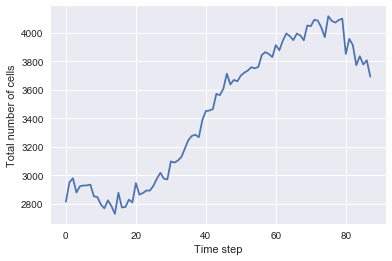

In [47]:
M = np.zeros(int(testobject.tot_time))
for i in range(int(testobject.tot_time)):
    M[i]=np.sum(testobject.pd2np()[2, :, :, i])
    
plt.plot(np.arange(int(testobject.tot_time)), M)
plt.xlabel('Time step')
plt.ylabel('Total number of cells')

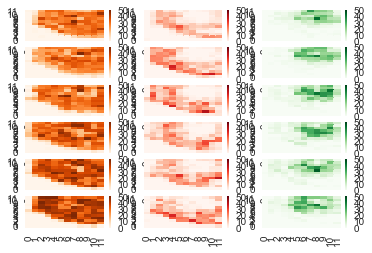

In [50]:
%matplotlib inline
grid = testobject.pd2np()
plotNum=6
time_step = int(testobject.tot_time/plotNum)
grn = grid[0,:,:,:]
red = grid[1,:,:,:]
both = grid[2,:,:,:]

# Plot heatmap for each time i*time_step
for i in range(plotNum):
    plt.subplot(plotNum,3,1+i*3)
    ax_b = sns.heatmap(both[:,:,i*time_step], vmin=0, vmax=50, 
                cmap="Oranges")
    ax_b.invert_yaxis()

    plt.subplot(plotNum,3,2+i*3)
    ax_r = sns.heatmap(red[:,:,i*time_step], vmin=0, vmax=50,
                cmap="Reds")
    ax_r.invert_yaxis()

    plt.subplot(plotNum,3,3+i*3)
    ax_g = sns.heatmap(grn[:,:,i*time_step], vmin=0, vmax=50,
                cmap="Greens")
    ax_g.invert_yaxis()

In [51]:
model.solver([0.001, 0.0001, 0.00001, 0.0001], testobject)

array([[[[  0.00000000e+00,   7.33152346e-09,   2.93310712e-08, ...,
            5.37415911e-05,   5.50230941e-05,   5.63199246e-05],
         [  0.00000000e+00,   7.33152346e-09,   2.93310712e-08, ...,
            5.37415911e-05,   5.50230941e-05,   5.63199246e-05],
         [  0.00000000e+00,   4.94320518e-05,   9.88663122e-05, ...,
            4.21060178e-03,   4.26025763e-03,   4.30991655e-03],
         ..., 
         [  0.00000000e+00,   7.91436677e-04,   1.58397218e-03, ...,
            7.12701205e-02,   7.21576882e-02,   7.30464203e-02],
         [  0.00000000e+00,   1.13743666e-03,   2.27592257e-03, ...,
            1.00507424e-01,   1.01736943e-01,   1.02967580e-01],
         [  0.00000000e+00,   1.13743666e-03,   2.27592257e-03, ...,
            1.00507424e-01,   1.01736943e-01,   1.02967580e-01]],

        [[  0.00000000e+00,   7.33152346e-09,   2.93310712e-08, ...,
            5.37415911e-05,   5.50230941e-05,   5.63199246e-05],
         [  0.00000000e+00,   7.33152346e-09,

In [79]:
arr = np.array([[0, 1, 2], [0, 4, 5], [0, 0, 8]])
args = np.nonzero(arr)
arr[args]

array([1, 2, 4, 5, 8])

In [72]:
12*12*88*3

38016

0.0